# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные со значением метрики качества *F1* не меньше 0.75. В вашем распоряжении набор данных с разметкой о токсичности правок.

**Инструкция по выполнению проекта**

1. Нужно загрузить и подготовьте данные;
2. Обучить разные модели;
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Выгружаем библиотеки и модули

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
import sys
from tqdm import tqdm

tqdm.pandas()

import warnings

from catboost import CatBoostClassifier, Pool
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from tqdm import notebook

### Выгружаем датасет

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

### Отключим некритические предупреждения в коде

In [3]:
warnings.filterwarnings("ignore")

### Посмотрим общую информацию о датасете

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


### Выведем на экран первые 10 строк датасета

In [5]:
df.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


### Оставим в тексте только буквенные символы и пробелы, и проведем лемматизацию

In [11]:
nlp.pipe_names
disabled_pipes = [ "parser",  "ner"]
nlp = spacy.load("en_core_web_sm", disable=disabled_pipes)

In [12]:
def clean_text(text):
    clean = nlp(" ".join(re.sub(r'[^a-zA-z]', ' ', text).split()))
    lemmatized_output = ' '.join([w.lemma_ for w in clean])
    return lemmatized_output

In [13]:
df['lemmatize'] = df['text'].progress_apply(clean_text)

100%|██████████| 159292/159292 [19:37<00:00, 135.28it/s]


In [14]:
df.head()

,Unnamed: 0,text,toxic,lemmatize
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour I m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


### Посмотрим на количество пропущенных значений в датасете

In [16]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
lemmatize     0
dtype: int64

### Посмотрим на количество явных дубликатов в датасете

In [17]:
df.duplicated().sum()

0

### Посмотрим на соотношение классов

In [18]:
class_ratio = df['toxic'].value_counts(normalize=True)
print(class_ratio)

0    0.898388
1    0.101612
Name: toxic, dtype: float64


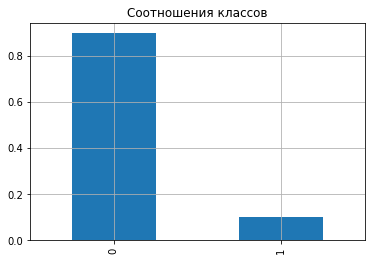

In [19]:
class_ratio.plot(kind = 'bar', grid = True)
plt.title('Соотношения классов');

Классы несбалансированы. 

### Выведем общий размер датасета

In [20]:
df.shape

(159292, 4)

### Проведем разделение на выборки

In [21]:
features = df.drop(['toxic'], axis = 1)
target = df['toxic']

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=12345)

### Выведем размеры выборок на экран

In [22]:
print(features_train.shape)
print(target_train.shape)

print(features_valid.shape)
print(target_valid.shape)

print(features_test.shape)
print(target_test.shape)

(95575, 3)
(95575,)
(31858, 3)
(31858,)
(31859, 3)
(31859,)


### Проведем борьбу с дисбалансом (Downsampling)

In [23]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.12)

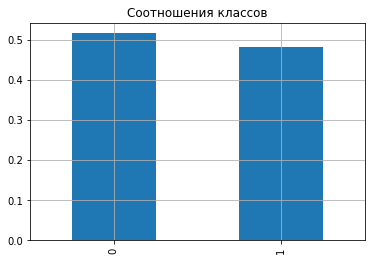

In [24]:
class_exited = target_train_downsampled.value_counts(normalize = (0,1))
class_exited.plot(kind = 'bar', grid = True)
plt.title('Соотношения классов')
plt.show()

### Получаем фичи для обучения

In [25]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemmatize'].values)
features_valid = count_tf_idf.transform(features_valid['lemmatize'].values)
features_test = count_tf_idf.transform(features_test['lemmatize'].values)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts = 3

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(95575, 117381)
(31858, 117381)
(31859, 117381)


***Вывод***

- Вывели общую информацию о датасете
- Оставили в тексте только кириллические символы и пробелы, и проведем лемматизацию
- Выявили отсутствие пропусков и явных дубликатов
- Разделили на выборки (обучающую, валидационную и тестовую)
- Провели борьбу с дисбалансом классов

## Обучение

### LogisticRegression

In [26]:
%%time
model_lr = LogisticRegression(C = 10)
model_lr.fit(features_train, target_train)
predict_lr = model_lr.predict(features_valid)
f_1_lr = f1_score(target_valid, predict_lr)
auc_roc_lr = roc_auc_score(target_valid, predict_lr)
print('F1:', f_1_lr)
print('AUC-ROC:', auc_roc_lr)

F1: 0.7808010816292041
AUC-ROC: 0.8433889971306674
CPU times: user 21.5 s, sys: 20.4 s, total: 41.9 s
Wall time: 42 s


### DecisionTreeClassifier

In [28]:
%%time

best_model_dt = None
best_result_dt = 0
best_depth_dt=0
for depth in tqdm(range(1, 25, 3)):
      
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth,class_weight='balanced') 
    model_dt.fit(features_train, target_train) 
    predictions_valid_dt = model_dt.predict(features_valid) 
    result_dt = f1_score(target_valid, predictions_valid_dt)
    if result_dt > best_result_dt:
        best_model_dt = model_dt
        best_result_dt = result_dt 
          
        best_depth_dt = depth
print("F1 наилучшей модели равно:", best_result_dt.round(2), end='')
print(' C глубиной:',best_depth_dt)

100%|██████████| 8/8 [00:50<00:00,  6.26s/it]

F1 наилучшей модели равно: 0.63 C глубиной: 19
CPU times: user 49.7 s, sys: 265 ms, total: 50 s
Wall time: 50.1 s


In [29]:
predict_dt = model_dt.predict(features_valid)
f_1_dt = f1_score(target_valid, predict_dt)
auc_roc_dt = roc_auc_score(target_valid, predict_dt)
print('F1:', f_1_dt)
print('AUC-ROC:', auc_roc_dt)

F1: 0.6226247558160184
AUC-ROC: 0.7546045229370708


### CatBoostClassifier

In [30]:
%%time

catboost = CatBoostClassifier(eval_metric="F1", 
                                   iterations=100, 
                                   max_depth=6, 
                                   learning_rate=0.9, 
                                   random_state=43)
catboost.fit(features_train, target_train, verbose=20)

0:	learn: 0.4540447	total: 2.42s	remaining: 3m 59s
20:	learn: 0.7512860	total: 38.1s	remaining: 2m 23s
40:	learn: 0.7774075	total: 1m 12s	remaining: 1m 44s
60:	learn: 0.7942689	total: 1m 48s	remaining: 1m 9s
80:	learn: 0.8087175	total: 2m 22s	remaining: 33.5s
99:	learn: 0.8230830	total: 2m 56s	remaining: 0us
CPU times: user 3min 20s, sys: 2.38 s, total: 3min 22s
Wall time: 3min 23s


In [31]:
%%time

predict_cat = catboost.predict(features_valid)
f_1_cat = f1_score(target_valid, predict_cat)
auc_roc_cat = roc_auc_score(target_valid, predict_cat)
print('F1:', f_1_cat)
print('AUC-ROC:', auc_roc_cat)

F1: 0.7623183564389512
AUC-ROC: 0.8374478470363534
CPU times: user 344 ms, sys: 11.8 ms, total: 356 ms
Wall time: 363 ms


In [32]:
report = pd.DataFrame(columns = ["LogisticRegression","DecisionTreeClassifier","CatBoostClassifier"],
                      index = ["F_1",
                               "AUC-ROC",
                               "Результат задания"])


report.iloc[0] = [f_1_lr, f_1_dt, f_1_cat]
report.iloc[1] = [auc_roc_lr, auc_roc_dt, auc_roc_cat]
report.iloc[2] = ["False","False","True"]

In [33]:
display(report)

,LogisticRegression,DecisionTreeClassifier,CatBoostClassifier
F_1,0.780801,0.622625,0.762318
AUC-ROC,0.843389,0.754605,0.837448
Результат задания,False,False,True


***Вывод***

Обучили модели LogisticRegression, DecisionTreeClassifier, CatBoostClassifier. Наилучшую метрику F1 (0.7801490514905148) показала модель LogisticRegression, поэтому тестирование будем проводить на этой Модели.

## Выводы

### Тестирование модели LogisticRegression

In [34]:
predict_lr_test = model_lr.predict(features_test)
f_1_lr_test = f1_score(target_test, predict_lr_test)
auc_roc_lr_test = roc_auc_score(target_test, predict_lr_test)
print('F1:', f_1_lr_test)
print('AUC-ROC:', auc_roc_lr_test)

F1: 0.767209668943773
AUC-ROC: 0.8348419574662445


### Построим график ROC-кривой

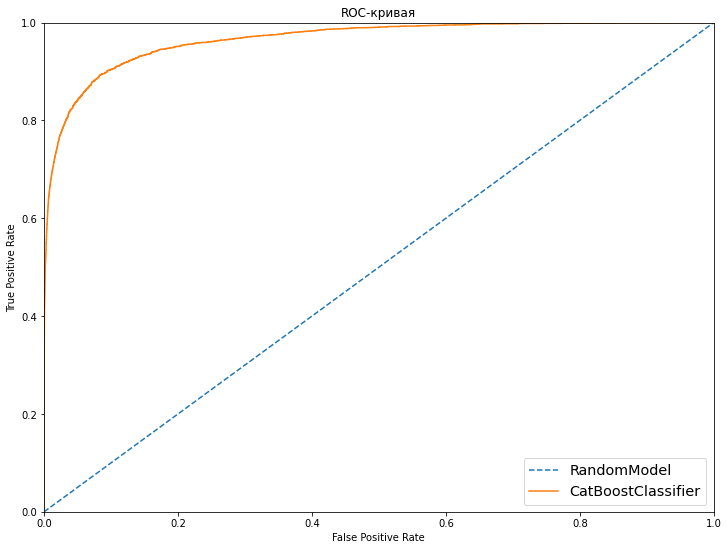

In [35]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')

probabilities_test = model_lr.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.plot(fpr, tpr, label='CatBoostClassifier')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Модель LogisticRegression на тестовой выбоке показала по метрике F1  = 0.7673970201577562 (по заданию она не менее 0.75). AUC-ROC на тестовой выборке равна 0.8347390540935904. Это говорит нам, что токсичные комментарии находятся лучше.